In [188]:
#libraries needed
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import explained_variance_score

# Importing and Exploration of the dataset 

In [189]:
df1 = pd.read_csv('Original.csv')
amazon = df1
amazon.head()

,Date,Open,High,Low,Close,Volume,Name
0,1/3/2006,47.47,47.85,46.25,47.58,7582127,AMZN
1,1/4/2006,47.48,47.73,46.69,47.25,7440914,AMZN
2,1/5/2006,47.16,48.20,47.11,47.65,5417258,AMZN
3,1/6/2006,47.97,48.58,47.32,47.87,6154285,AMZN
4,1/9/2006,46.55,47.10,46.40,47.08,8945056,AMZN


In [190]:
amazon.shape

(3019, 7)

In [191]:
amazon.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,299.335310,302.371163,296.037695,299.376231,5.931712e+06
std,280.120547,281.826442,277.927134,279.980161,5.122034e+06
min,26.090000,26.300000,25.760000,26.070000,9.864350e+05
25%,81.175000,82.580000,79.725000,81.090000,3.137037e+06
50%,205.330000,208.000000,202.100000,205.440000,4.724100e+06
75%,375.570000,379.155000,373.000000,375.140000,7.135246e+06
max,1204.880000,1213.410000,1191.150000,1195.830000,1.044046e+08


In [192]:
amazon['Date'].min()

'1/10/2006'

In [193]:
amazon['Date'].max()

'9/9/2016'

In [194]:
amazon.isnull().sum() 

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

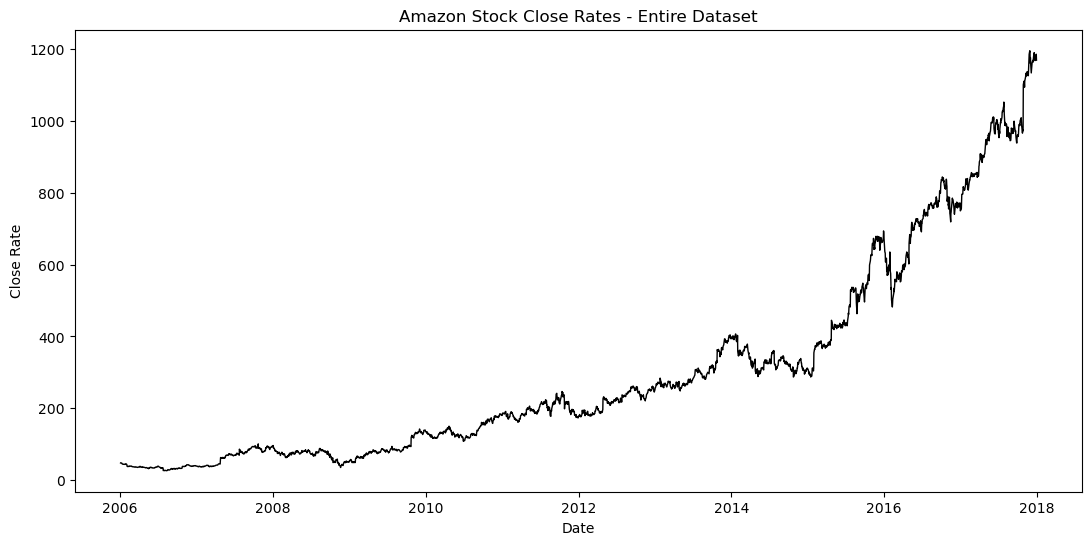

In [195]:
# Set 'Date' column as index and convert index to datetime format
amazon['Date'] = pd.to_datetime(amazon['Date'], format='%m/%d/%Y')
amazon.set_index('Date', inplace=True)

# Resample daily data to yearly mean
yearly_mean = amazon['Close'].resample('Y').mean()


plt.figure(figsize=(13, 6))
plt.plot(amazon.index, amazon['Close'], linestyle='-', color='black', linewidth=1)
plt.title('Amazon Stock Close Rates - Entire Dataset')
plt.xlabel('Date')
plt.ylabel('Close Rate')
plt.show()

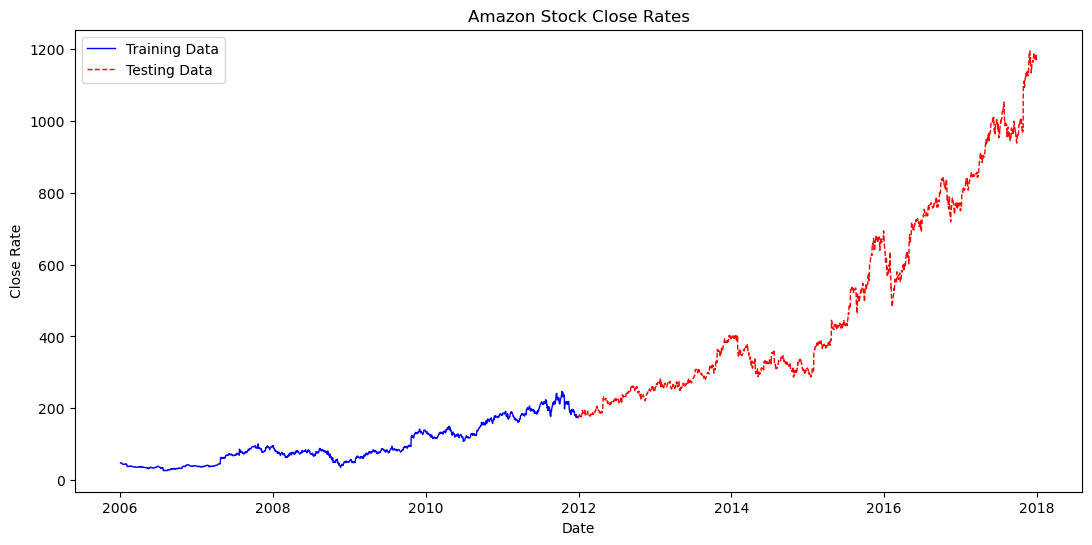

In [196]:
# Splitting the data into a training set and a test set is a common practice for assessing the accuracy of a time series model.
split_date = '12/29/2011'  # 3020/2
data_train = amazon.loc[amazon.index <= split_date]
data_test = amazon.loc[amazon.index > split_date]

# Plotting all datasets of 'Close' prices on the same chart
plt.figure(figsize=(13, 6))
plt.plot(data_train.index, data_train['Close'], linestyle='-', color='blue', linewidth=1, label='Training Data')
plt.plot(data_test.index, data_test['Close'], linestyle='--', color='red', linewidth=1, label='Testing Data')
plt.title('Amazon Stock Close Rates')
plt.xlabel('Date')
plt.ylabel('Close Rate')
plt.legend()
plt.show()


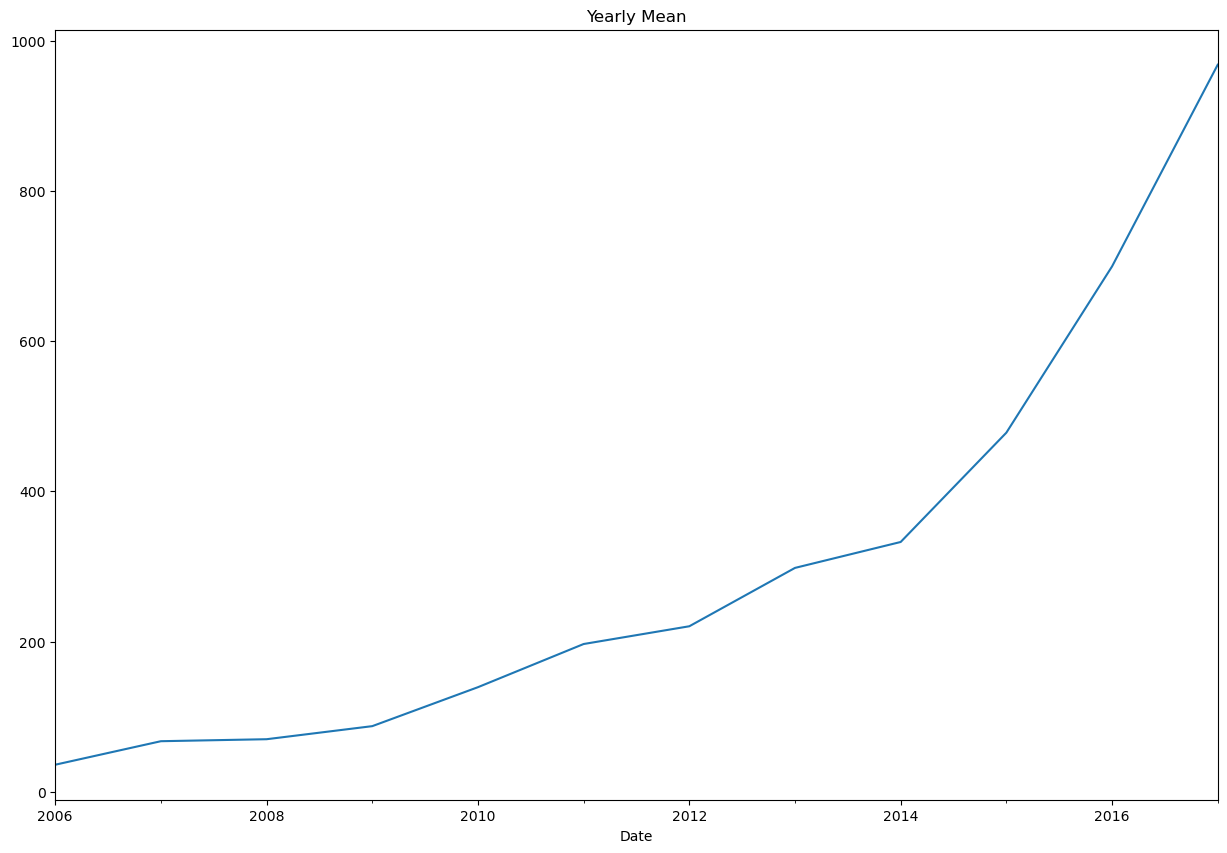

In [197]:
yearly_mean.plot(figsize=(15, 10))
plt.title('Yearly Mean')
plt.show()

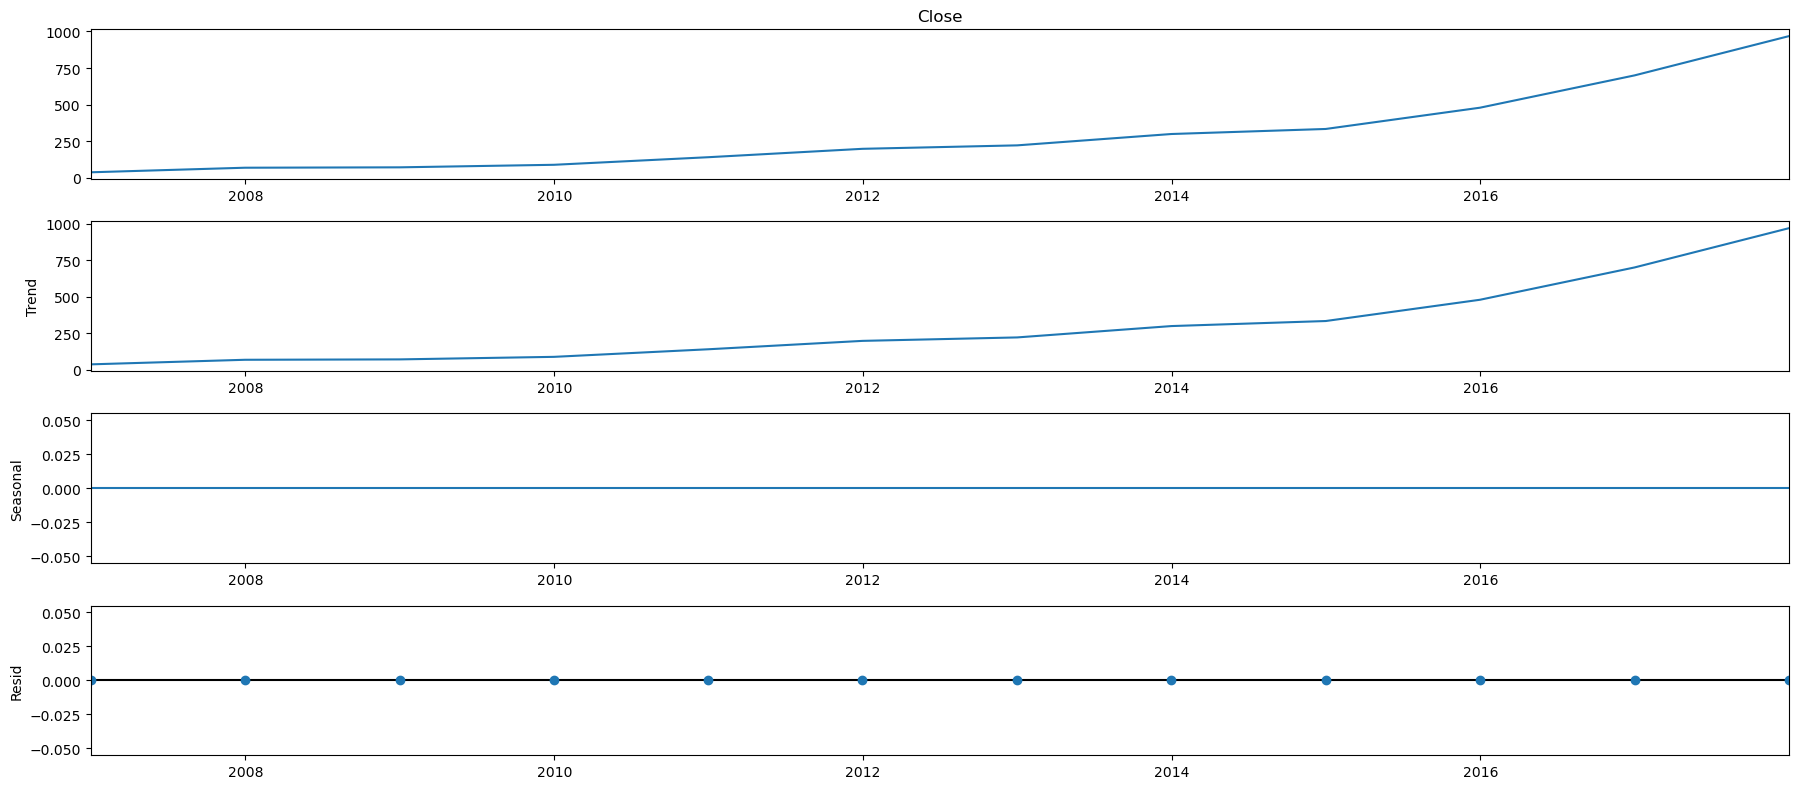

In [198]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(yearly_mean, model='additive')
fig = decomposition.plot()
plt.show()

In [199]:
yearly_mean

Date
2006-12-31     35.909323
2007-12-31     67.229482
2008-12-31     69.880040
2009-12-31     87.281825
2010-12-31    139.169602
2011-12-31    196.663849
2012-12-31    220.303680
2013-12-31    298.032222
2014-12-31    332.550913
2015-12-31    478.138294
2016-12-31    699.523135
2017-12-31    968.167012
Freq: A-DEC, Name: Close, dtype: float64

I deicided to try out resampling data. As Resampling data can fix frequency like hourly or daily offers benefits like filling gaps, noise reduction, and data size reduction. When I plotted the yearly_mean, its no different from the original data set.

# Dickey-Fuller Test 
a statistical approach of checking if the time series object is stationary or not. 


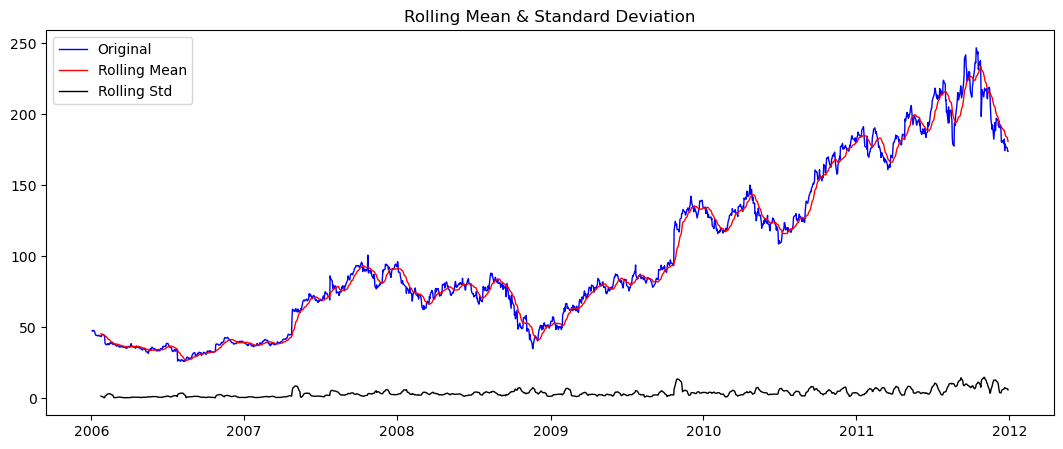

Results of Dickey-Fuller Test:
Test Statistic                   -0.793599
p-value                           0.820995
#Lags Used                        0.000000
Number of Observations Used    1508.000000
Critical Value (1%)              -3.434694
Critical Value (5%)              -2.863459
Critical Value (10%)             -2.567791
dtype: float64


In [200]:

def evaluate_stationarity(timeseries, t=30):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=t).mean()
    rolstd = timeseries.rolling(window=t).std()

    # Plot rolling statistics
    plt.figure(figsize=(13, 5))
    orig = plt.plot(timeseries, color='blue',  linewidth=1, label='Original')
    mean = plt.plot(rolmean, color='red',  linewidth=1, label='Rolling Mean')
    std = plt.plot(rolstd, color='black',  linewidth=1, label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)
    

# Call the function
evaluate_stationarity(data_train['Close'], 15)
    

Since the p-value (0.820995) is greater than 0.05 (the common significance level for hypothesis testing), we fail to reject the null hypothesis. This means there's not enough evidence to say the data is stationary at the 5% significance level.

# Log Transformation

Applying transformations lie log, cube root and etc can enable the series to become stationary

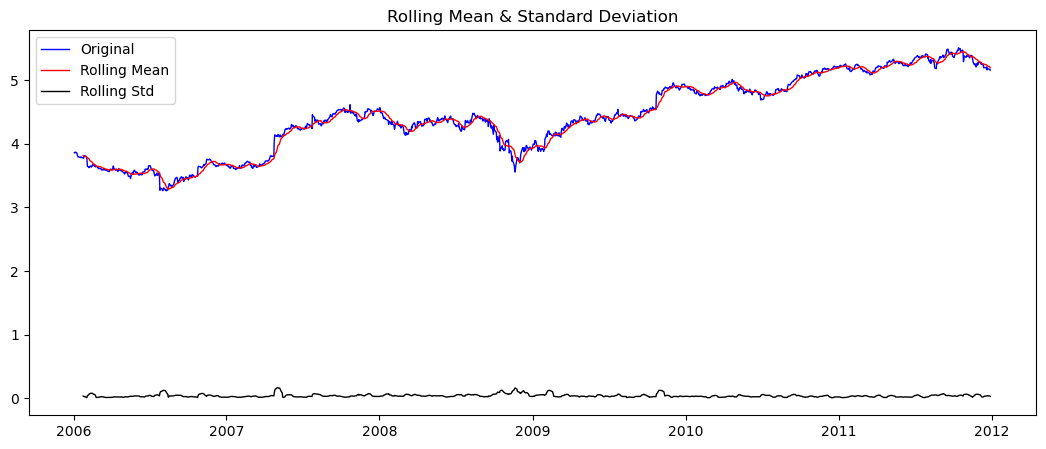

Results of Dickey-Fuller Test:
Test Statistic                   -0.742973
p-value                           0.835303
#Lags Used                        2.000000
Number of Observations Used    1506.000000
Critical Value (1%)              -3.434700
Critical Value (5%)              -2.863461
Critical Value (10%)             -2.567793
dtype: float64


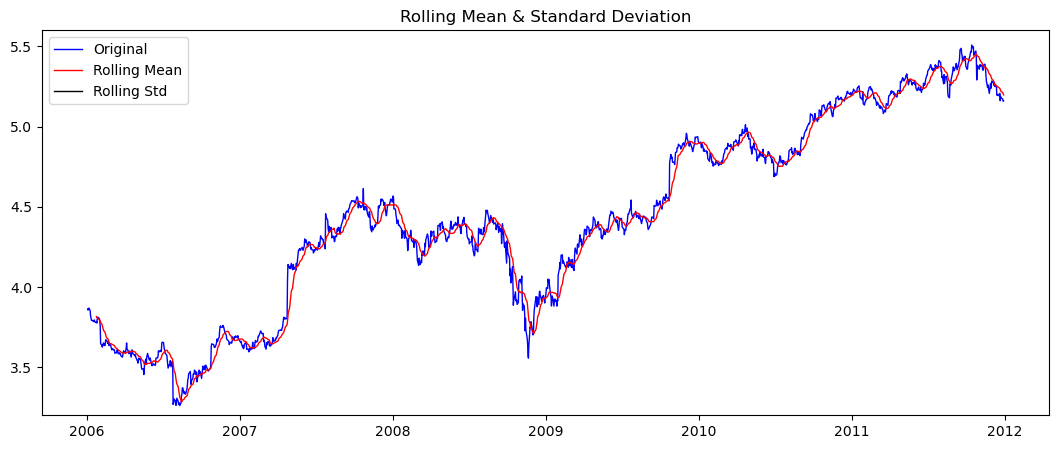

In [201]:
#Applying Log Transformation to Time Series Object
data_log = np.log(data_train['Close']) #Initiaalize
evaluate_stationarity(data_log, 15)

# Determine rolling statistics
rolmean = data_log.rolling(window=15).mean()
rolstd = data_log.rolling(window=15).std()

# Plot rolling statistics
plt.figure(figsize=(13,5))
orig = plt.plot(data_log, color='blue',label='Original',linewidth=1 )
mean = plt.plot(rolmean, color='red', label='Rolling Mean',linewidth=1)
std = plt.plot(rolstd, color='black', label = 'Rolling Std',linewidth=1)

plt.legend(loc='best')
plt.ylim([3.2,5.6])
plt.title('Rolling Mean & Standard Deviation')
plt.show()

The p-value results increased slightly before and since the p-value is still greater than 0.05, this means the data is not stationary. This proved that log transformation failed to make the object stationary. 

# Square Root Transformation
Applying transformations lie log, cube root and etc can enable the series to become stationary

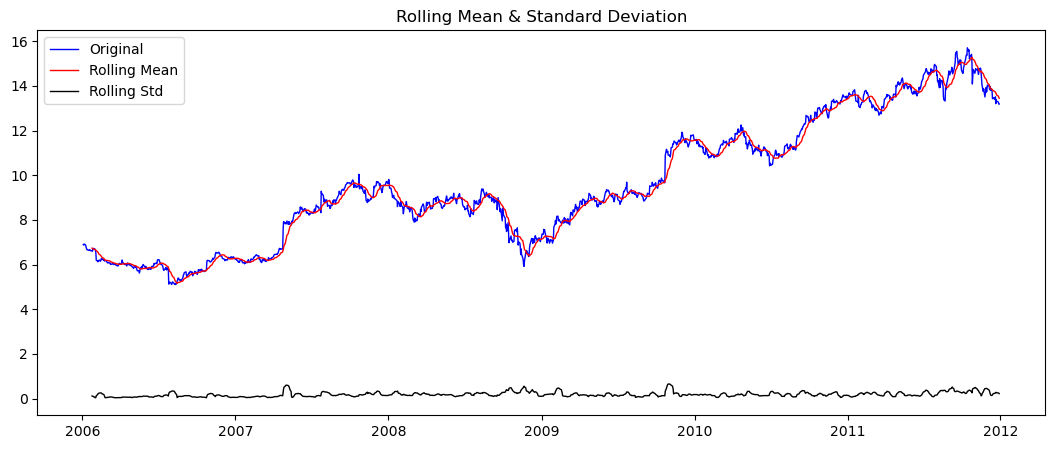

Results of Dickey-Fuller Test:
Test Statistic                   -0.668771
p-value                           0.854674
#Lags Used                        2.000000
Number of Observations Used    1506.000000
Critical Value (1%)              -3.434700
Critical Value (5%)              -2.863461
Critical Value (10%)             -2.567793
dtype: float64


In [202]:
data_sqrt = np.sqrt(data_train['Close'])
evaluate_stationarity(data_sqrt, 15)

The square root transformation might have had a minimal effect on the stationarity of the data. The p-value has increased slightly, it's still not strong enough evidence to definitively say the data is stationary.

# Cube Root Transformation 
Applying transformations lie log, cube root and etc can enable the series to become stationary

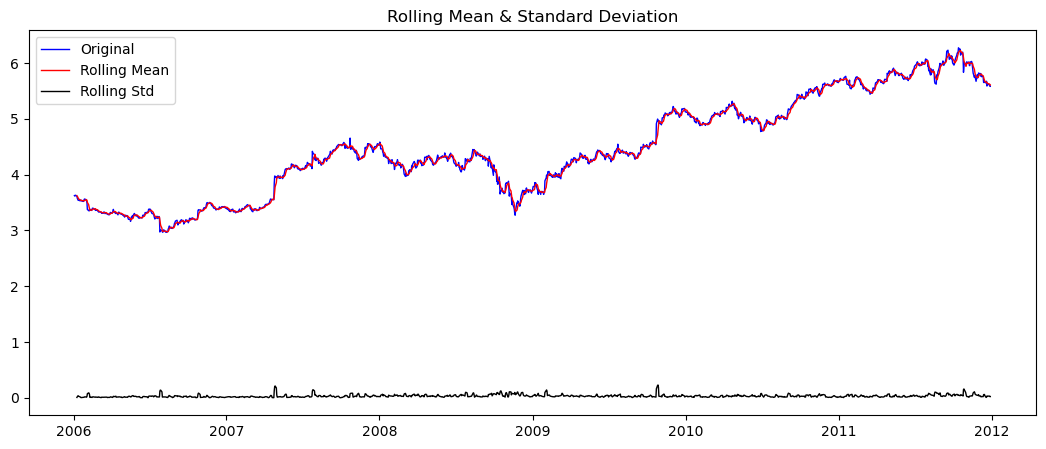

Results of Dickey-Fuller Test:
Test Statistic                   -0.681869
p-value                           0.851390
#Lags Used                        2.000000
Number of Observations Used    1506.000000
Critical Value (1%)              -3.434700
Critical Value (5%)              -2.863461
Critical Value (10%)             -2.567793
dtype: float64


In [203]:
data_cbrt = np.cbrt(data_train['Close'])
evaluate_stationarity(data_cbrt, 5)

# Exercise

1. Determine the e cube transformation of our time series. Does it improve the value of the test statistic?

Neither the square root nor the cube root transformation seems to be sufficient to make your data statistically stationary based on the Dickey-Fuller test results.

# Moving Average Smoothing

is a technique commonly used in time series analysis and signal processing to reduce noise and highlight underlying trends or patterns in data. 

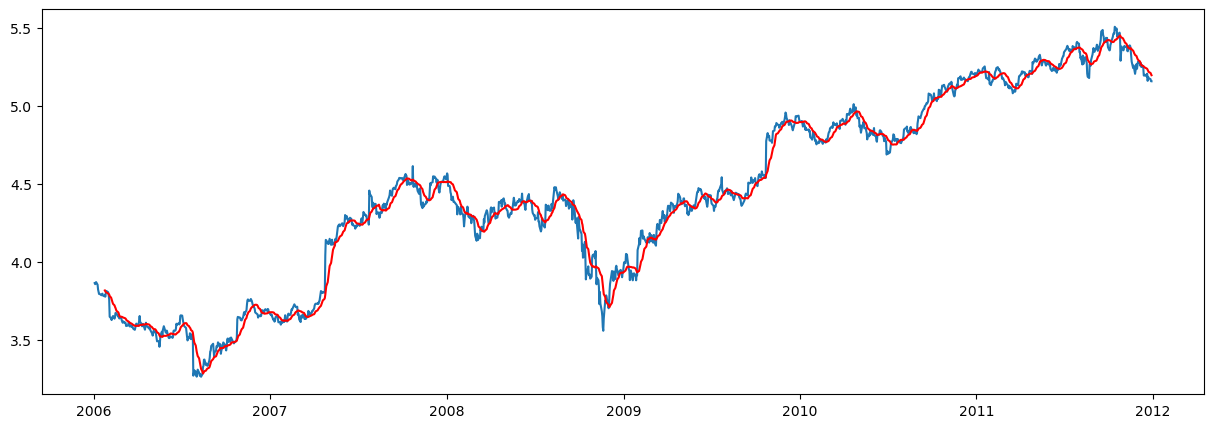

Date
2006-01-03        NaN
2006-01-04        NaN
2006-01-05        NaN
2006-01-06        NaN
2006-01-09        NaN
2006-01-10        NaN
2006-01-11        NaN
2006-01-12        NaN
2006-01-13        NaN
2006-01-17        NaN
2006-01-18        NaN
2006-01-19        NaN
2006-01-20        NaN
2006-01-23        NaN
2006-01-24   -0.03061
Name: Close, dtype: float64

In [204]:
#Applying Moving Average Smoothing to the Time Series Object

moving_avg = data_log.rolling(window=15).mean()
plt.figure(figsize=(15, 5))
plt.plot(data_log)
plt.plot(moving_avg, color='red')
plt.show()

#Printing Trendless Time Series Object
data_log_moving_avg_diff = data_log - moving_avg
data_log_moving_avg_diff.head(15)


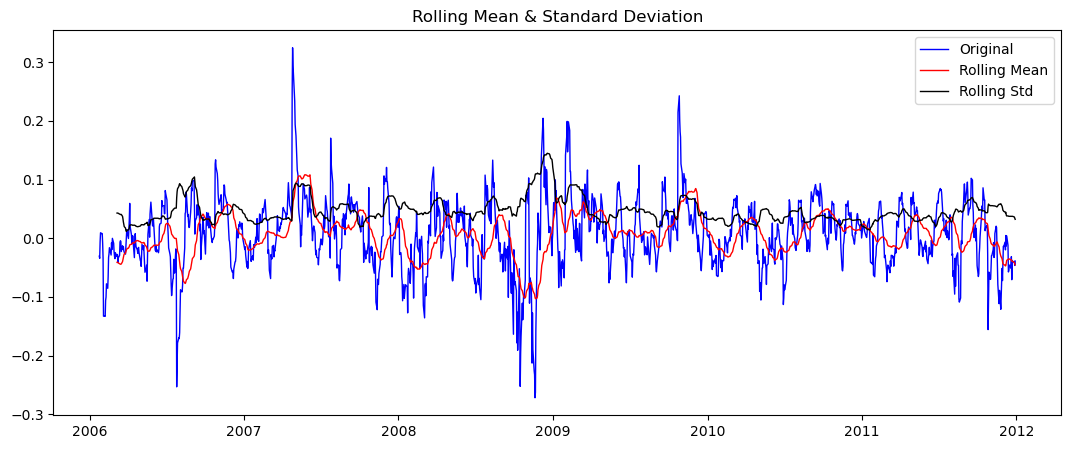

Results of Dickey-Fuller Test:
Test Statistic                -7.129307e+00
p-value                        3.551929e-10
#Lags Used                     1.400000e+01
Number of Observations Used    1.480000e+03
Critical Value (1%)           -3.434776e+00
Critical Value (5%)           -2.863495e+00
Critical Value (10%)          -2.567811e+00
dtype: float64


In [205]:
#Evaluating Trendless Time Series for Stationary

data_log_moving_avg_diff.dropna(inplace=True)
evaluate_stationarity(data_log_moving_avg_diff)

# Differencing

Differencing stabilizes the mean of a time series by removing
changes in the level. 

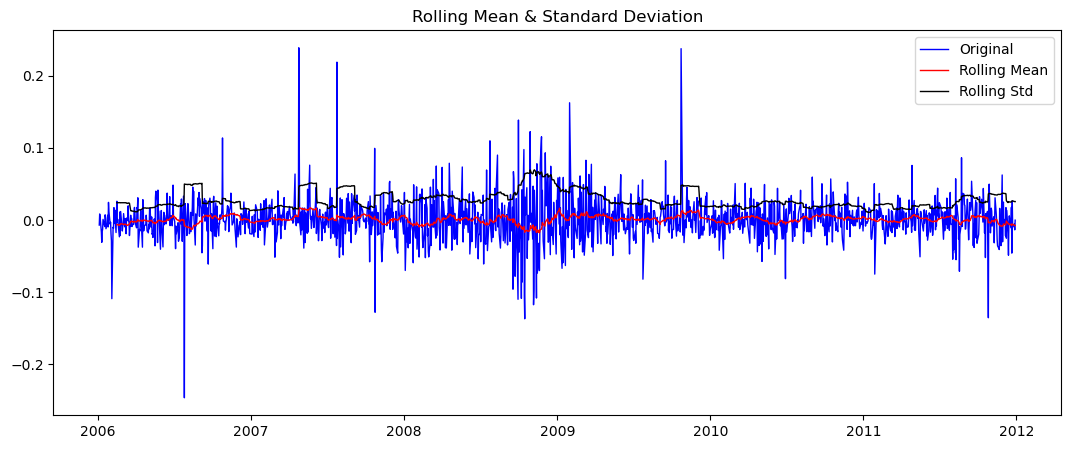

Results of Dickey-Fuller Test:
Test Statistic                  -29.647495
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1506.000000
Critical Value (1%)              -3.434700
Critical Value (5%)              -2.863461
Critical Value (10%)             -2.567793
dtype: float64


In [206]:
#Applying First-Order Differencing to the Log Version of the Time Series Object 
data_log_diff = data_log - data_log.shift()
data_log_diff.dropna(inplace=True)
evaluate_stationarity(data_log_diff)

the rolling mean and rolling standard deviation appear to be almost constant.Since the p-value (0.000000) is much less than 0.05 (the common significance level), we can reject the null hypothesis that the data is not stationary. This means there's strong evidence to conclude that the data is now stationary.

# Exercise 

1. Apply second- and third-order differencing to our log transformed series. Did it make the log transformed series stationary?

Based on the results, we can confidently say that the data is stationary after applying either 2nd or 3rd order differencing. The 2nd order differencing appears slightly more conclusive based on the test statistic and p-value.

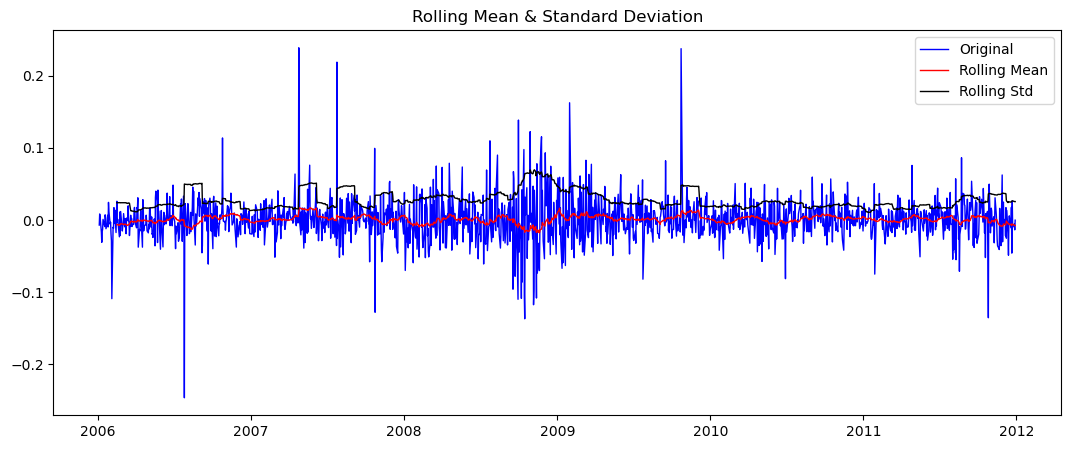

Results of Dickey-Fuller Test:
Test Statistic                  -29.647495
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1506.000000
Critical Value (1%)              -3.434700
Critical Value (5%)              -2.863461
Critical Value (10%)             -2.567793
dtype: float64


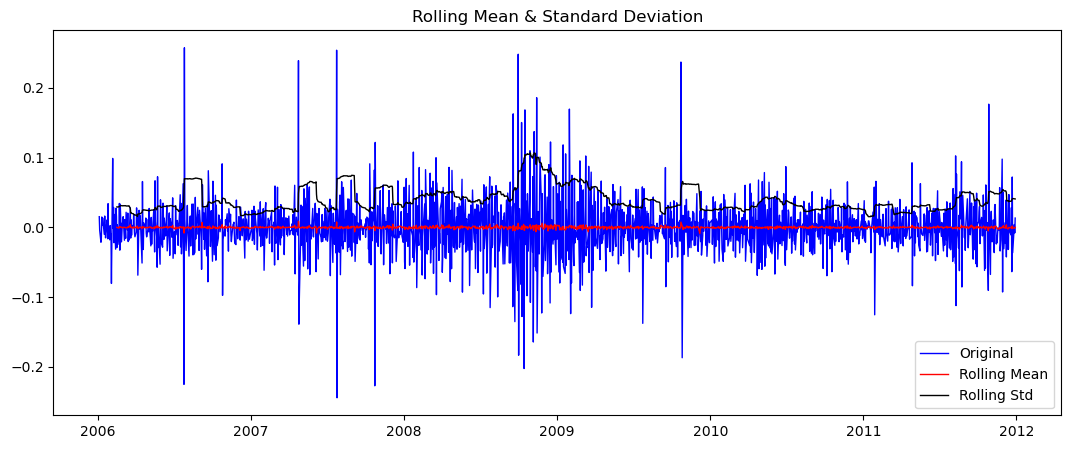

Results of Dickey-Fuller Test:
Test Statistic                -1.380862e+01
p-value                        8.311489e-26
#Lags Used                     2.300000e+01
Number of Observations Used    1.483000e+03
Critical Value (1%)           -3.434767e+00
Critical Value (5%)           -2.863491e+00
Critical Value (10%)          -2.567809e+00
dtype: float64


In [207]:
#Applying second-order differencing
data_log_diff_2 = data_log - data_log.shift()
data_log_diff_2.dropna(inplace=True)
evaluate_stationarity(data_log_diff_2)

#Applying Third-Order Differencing
data_log_diff_3 = data_log_diff_2 - data_log_diff_2.shift()
data_log_diff_3.dropna(inplace=True)
evaluate_stationarity(data_log_diff_3)


# Decomposition 
another approach to eliminate trend and seasonality from a time
series to make it stationary in nature. It does that by dividing the time series into three
components: trend, seasonality, and residuals. 

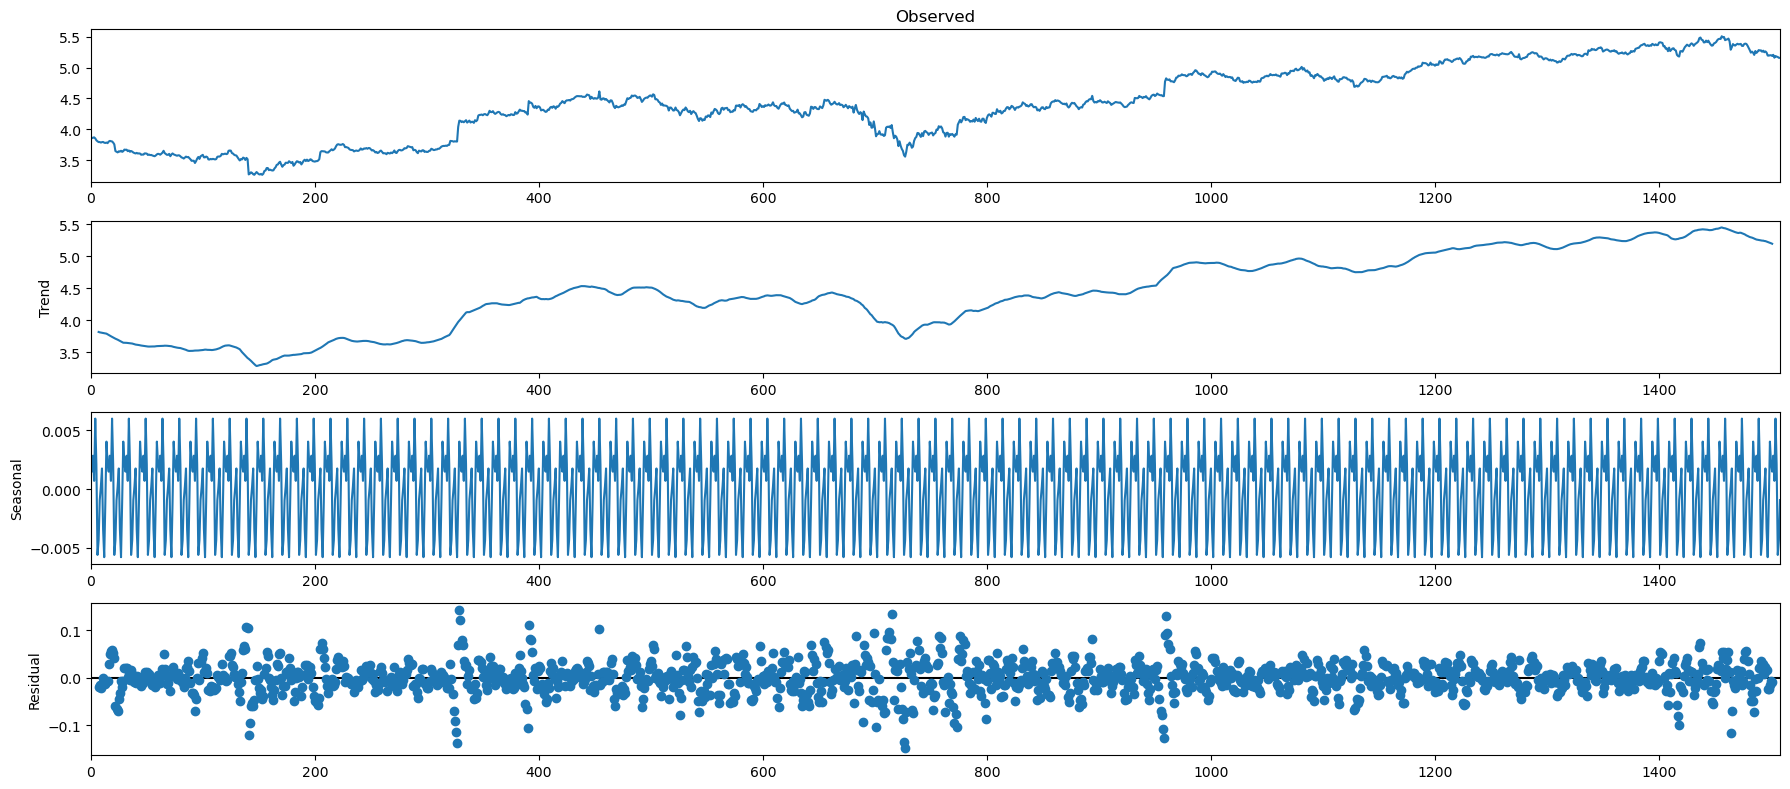

In [208]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = seasonal_decompose(list(data_log), period=15)
fig = decomposition.plot()
plt.show()

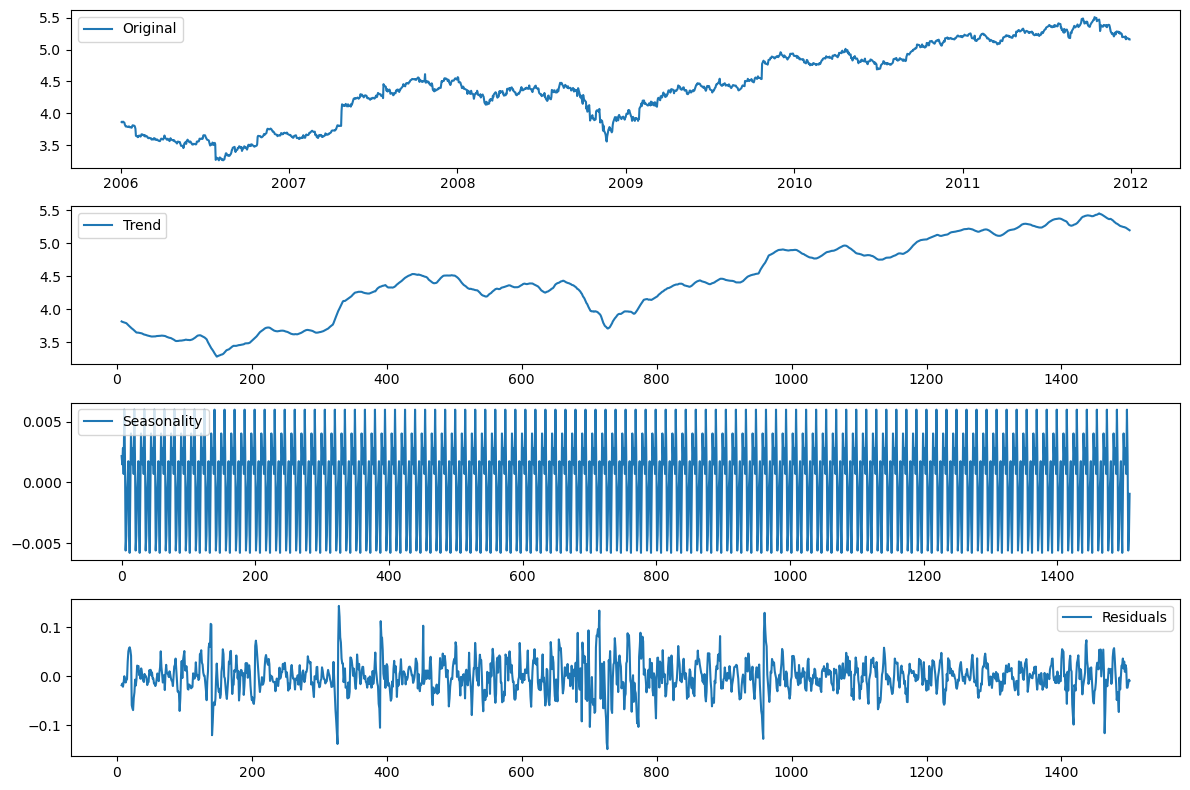

In [209]:
decomposition = seasonal_decompose(list(data_log), period=15)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


The plot above clearly shows that the Close is unstable, along with its obvious seasonality.



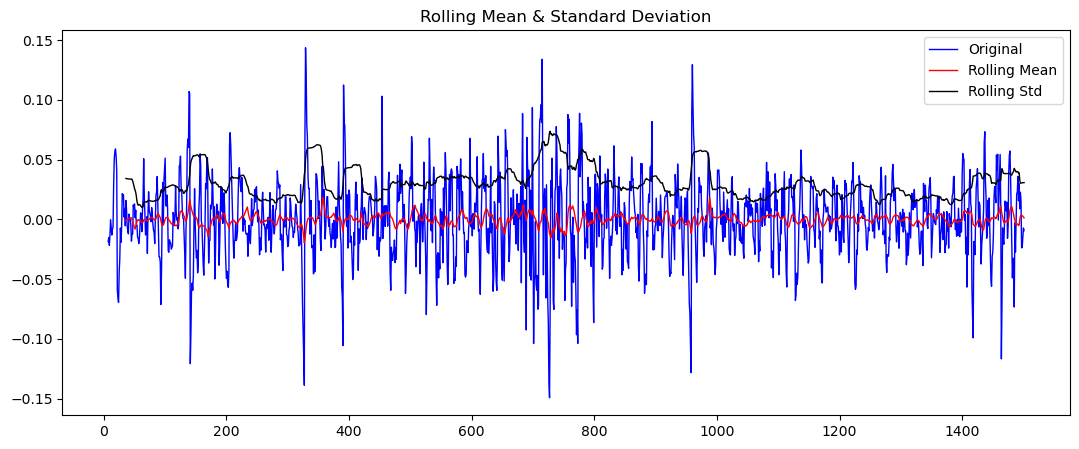

Results of Dickey-Fuller Test:
Test Statistic                -1.267251e+01
p-value                        1.235716e-23
#Lags Used                     2.200000e+01
Number of Observations Used    1.472000e+03
Critical Value (1%)           -3.434800e+00
Critical Value (5%)           -2.863505e+00
Critical Value (10%)          -2.567816e+00
dtype: float64


In [210]:
data_log_decompose = pd.Series(residual)
data_log_decompose.dropna(inplace=True)
evaluate_stationarity(data_log_decompose)

Since the test statistic is significantly lower than the critical values at any reasonable level of significance (1%, 5%, or 10%), and the p-value is extremely low, we can reject the null hypothesis of non-stationarity. Therefore, the residual component obtained after seasonal decomposition is likely stationary. 

# Autocorrelation using Durbin Watson Statistic
A statistical method to measure autocorrelation within the log transformed time series

In [211]:
sm.stats.durbin_watson(data_log_diff)


2.030927204130338

This indicates the presence of no autocorrelation in the log transformed differencing applied time series (Which is good).

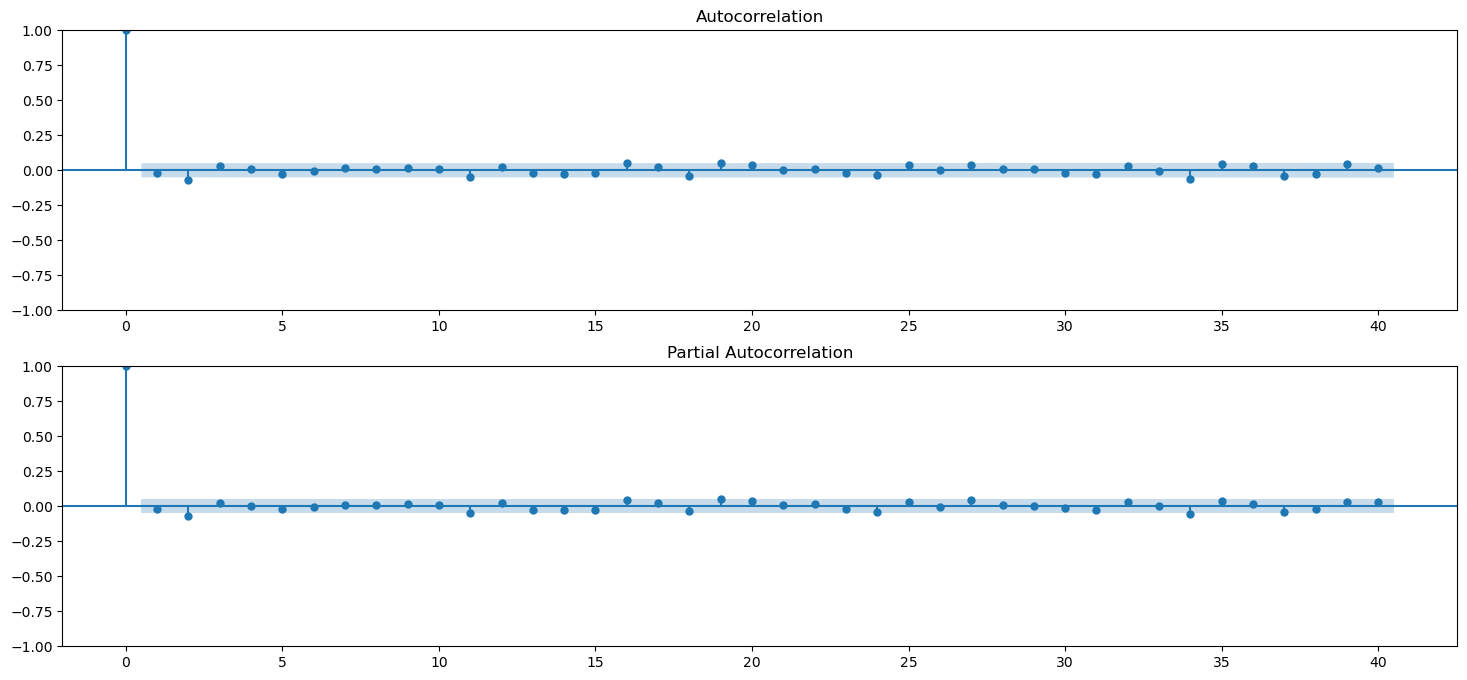

In [215]:
#Plotting Correlograms for ACF and PACF on Log Transformed Differencing Applied Time Series

ax1 = plt.subplot(211)
fig = sm.graphics.tsa.plot_acf(data_log_diff.squeeze(), lags=40, ax=ax1)
ax2 = plt.subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_log_diff, lags=40, ax=ax2, method='ywm')

#The horizontal axis (x-axis) likely represents the number of lags used in the test, 
#while the vertical axis (y-axis) likely represents the test statistic value.

the ACF and PACF correlograms should a spike at 1 lag with no correlations to come on the later time lags. T

# Auto-Regressive

C:\Users\canet\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\canet\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\canet\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


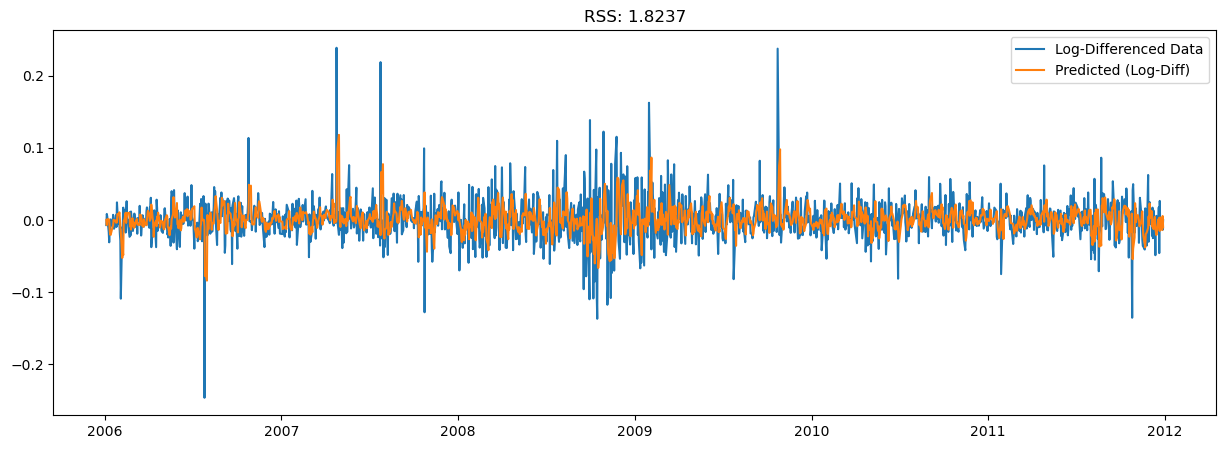

In [213]:
#Applying AR Model to Log Transformed Differencing Applied Time Series

#MAuto Regressive 
arima_order = (2, 1, 0)
plt.figure(figsize=(15, 5))

model = ARIMA(data_log_diff, order=arima_order)
results_AR_210 = model.fit()
plt.plot(data_log_diff.index, data_log_diff, label='Log-Differenced Data')
plt.plot(results_AR_210.fittedvalues.index, results_AR_210.fittedvalues, label='Predicted (Log-Diff)')
plt.title('RSS: %.4f'% sum((results_AR_210.fittedvalues-data_log_diff)**2))
plt.legend()
plt.show()



The decreasing RSS suggests that the model's predictions are increasingly close to the observed values in the input series.

# Moving Average


C:\Users\canet\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\canet\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\canet\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


TypeError: ARIMA.fit() got an unexpected keyword argument 'disp'

# Combined Model

# Exercise
1. Repeat the above steps by applying decomposition instead of
differencing. Did it improve the forecast accuracy?
2. Repeat the exercise by changing the parameter values of p, d, and q for the
ARMA, and ARIMA models. Then compute the test statistics to see if a given
combination of these parameters yields a better forecast accuracy.